In [1]:
import tensorflow as tf
from util import *
from util.parser import *
from util.img_kit import *
from IPython import display
import numpy as np
from scipy import ndimage
from scipy import misc
from os import walk
import os
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (10.0, 10) # set default size of plots


In [2]:
""" Load data """
img_folder = "data/moving-box/frames/square"
# img_folder = "data/moving-box/frames/moving-two-box-uniform"
# img_folder = "data/kid-conversation"
# img_folder = "data/kid-swing"
imgs = [p[2] for p in walk(img_folder)][0]
imgs = list(filter(lambda x: not x.startswith("."), imgs))
prefix, postfix = imgs[0].split("-")[0], imgs[0].split(".")[1]
print("Total Images: {}".format(len(imgs)))
print("From:         {}".format(imgs[0]))
print("To:           {}".format(imgs[-1]))

Total Images: 131
From:         square-001.jpeg
To:           square-131.jpeg


In [3]:
gap = 1
base_index = parse_img_index(imgs[0])
to = parse_img_index(imgs[-1]) - (len(imgs)-1)%(gap + 1)
num_intervals = (to-base_index)//(gap + 1)

print("Select Range:  {} -> {} | {} Intervals".format(base_index, to, num_intervals))

Select Range:  1 -> 131 | 65 Intervals


In [4]:
def index_to_img(i):
    return "{}/{}-{}.{}".format(img_folder, prefix, "%03d"%(base_index + i), postfix)

In [6]:
x_index = [i*gap for i in range(num_intervals + 1)]
mid_index = [x + (gap+1)//2 for x in x_index[:-1]]
X_train = np.concatenate([misc.imread(index_to_img(i))[np.newaxis, ...] for i in x_index], axis=0)
y_train = np.concatenate([misc.imread(index_to_img(i))[np.newaxis, ...] for i in mid_index], axis=0)
X_train = X_train.astype('float32')
y_train = X_train.astype('float32')
# mean_image = np.mean(X_train, axis = 0)
# X_train -= mean_image
# y_train -= mean_image
# X_train /= 255
# y_train /= 255
#y = [misc.imread(index_to_img(i)) for i in mid_index]  # ground truth of images in betwen
print("Image shape: {}".format(X_train[0].shape))
print(X_train.shape)
print(X_train.shape)

Image shape: (256, 256, 3)
(66, 256, 256, 3)
(66, 256, 256, 3)


## Parameter

In [7]:
batch_size = 8

In [8]:
def sample():
    """
    Select a batch size of data-point from X and y
    """
    start = np.random.choice(list(range(num_intervals)), size = batch_size)
    start_x = X_train[start,:,:,:]
    end_x = X_train[start + 1,:,:,:]
    batch_x = np.concatenate([start_x,end_x], axis = 3)
    batch_y = y_train[start,:,:,:]
    return((batch_x, batch_y))

In [9]:
sample()[0].shape

(8, 256, 256, 6)

In [25]:
def conv_pool_block(inputs, conv_filter, conv_kernel, pool_size, pool_stride):
    conv1 = tf.layers.conv2d(inputs, conv_filter, conv_kernel, padding='same', activation=tf.nn.relu)
    pooled = tf.layers.max_pooling2d(conv1, pool_size, pool_stride)
    return pooled


In [10]:
tf.reset_default_graph()
def my_model(X,y):
    block1 = conv_pool_block(X, 48, (3,3), (2,2), (2,2))  #(N, 128, 128, 48)
    block2 = conv_pool_block(X, 96, (3,3), (2,2), (2,2))  #(N, 64, 64, 96)
    
    conv3 = conv_layer(conv2, 'conv3', [3,3,96,12],[1,1,1,1], [12]) # (N, 4, 4, 64)
    conv4 = conv_layer(conv3, 'conv4', [3,3,12,3],[1,1,1,1], [3], activation = 'None') # (N, 4, 4, 64)
    y_out = conv4
    return y_out

X = tf.placeholder(tf.float32, [None, 256, 256, 6])
y = tf.placeholder(tf.float32, [None, 256, 256, 3])

learning_rate = 1e-3
y_out = my_model(X,y)

mean_loss = tf.reduce_mean(tf.nn.l2_loss(y_out - y))
optimizer = tf.train.AdamOptimizer(learning_rate)
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

pass

In [23]:
tf.reset_default_graph()
def my_model(X,y):
    conv1 = conv_layer(X, 'conv1', [3,3,6,48],[1,1,1,1], [48])  # (N, 256, 256, 48)
    conv2 = conv_layer(conv1, 'conv2', [3,3,48,96],[1,1,1,1], [96]) # (N, 8, 8, 64)
    conv3 = conv_layer(conv2, 'conv3', [3,3,96,12],[1,1,1,1], [12]) # (N, 4, 4, 64)
    conv4 = conv_layer(conv3, 'conv4', [3,3,12,3],[1,1,1,1], [3], activation = 'None') # (N, 4, 4, 64)
    y_out = conv4
    return y_out

X = tf.placeholder(tf.float32, [None, 256, 256, 6])
y = tf.placeholder(tf.float32, [None, 256, 256, 3])

learning_rate = 1e-3
y_out = my_model(X,y)

mean_loss = tf.reduce_mean(tf.nn.l2_loss(y_out - y))
optimizer = tf.train.AdamOptimizer(learning_rate)
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

pass

batch : 0  loss: 5.827e+10
batch : 5  loss: 9.912e+09
batch : 10  loss: 2.578e+09
batch : 15  loss: 5.342e+08
batch : 20  loss: 6.206e+08
batch : 25  loss: 7.023e+08


KeyboardInterrupt: 

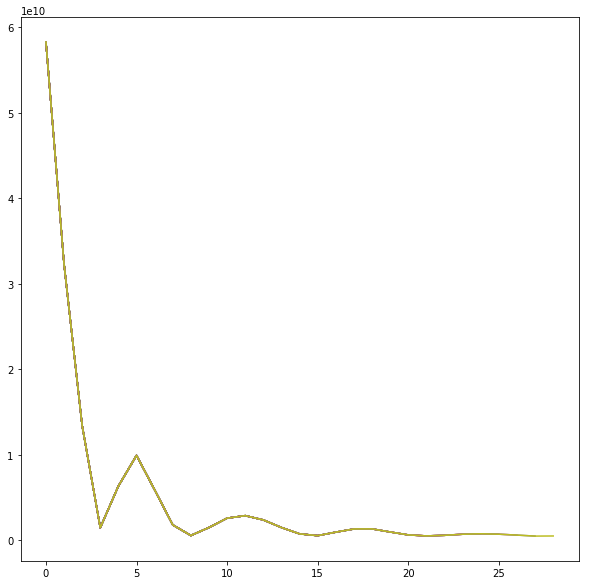

In [24]:
epochs = 60
sess =  tf.Session()
sess.run(tf.global_variables_initializer())
variables = [mean_loss,train_step]
history = []
for e in range(epochs):
    sampled = sample()
    feed_dict = {X: sampled[0], y: sampled[1]}
    loss, _ = sess.run(variables,feed_dict=feed_dict)
    history.append(loss)
    if e % 5 == 0:
        print('batch : {0}  loss: {1:.3e}'.format(e, loss))
    plt.plot(history)

In [13]:
return_variables = [mean_loss, y_out]
print(mean_loss)
print(y_out)
sampled = sample()
feed_dict = {X: sampled[0], y: sampled[1]}
result = sess.run(return_variables, feed_dict=feed_dict)

Tensor("Mean:0", shape=(), dtype=float32)
Tensor("conv3/add:0", shape=(?, 256, 256, 3), dtype=float32)


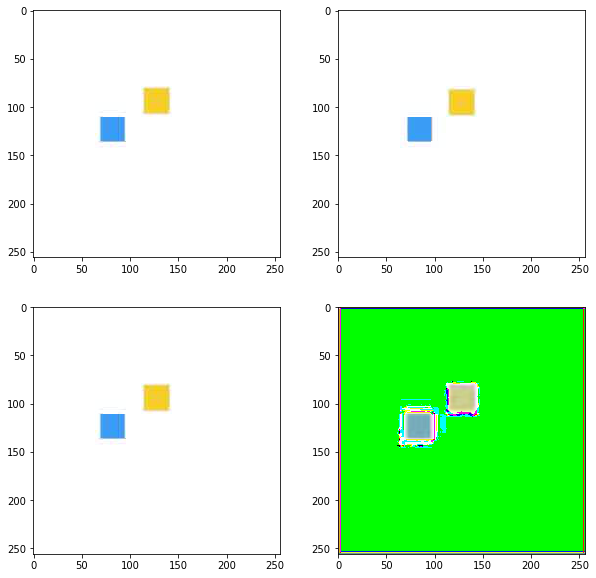

In [19]:
test_ind = 3
plt.subplot(221)
plt.imshow((sampled[0][test_ind,:,:,:3]).astype('uint8'))
plt.subplot(222)
plt.imshow((sampled[0][test_ind,:,:,3:]).astype('uint8'))
plt.subplot(223)
plt.imshow((sampled[1][test_ind,:,:,:]).astype('uint8'))
plt.subplot(224)
y_pred = result[1]
plt.imshow((y_pred[test_ind,:,:,:]).astype('uint8'))

In [21]:
y_pred[test_ind,:,:,:].astype('uint8')

array([[[192,   4, 167],
        [247,  97, 243],
        [ 13, 170, 231],
        ..., 
        [ 18, 144, 228],
        [243, 148, 220],
        [136, 154, 167]],

       [[176,  68, 195],
        [236, 156,  46],
        [238,   6,   5],
        ..., 
        [240,   7,  36],
        [248, 240,  35],
        [153, 209, 207]],

       [[217,  81, 161],
        [242, 175, 248],
        [251,  15, 199],
        ..., 
        [247,  21, 235],
        [253,   1, 250],
        [160, 210, 199]],

       ..., 
       [[190, 101, 173],
        [221, 190,  22],
        [245,  31, 231],
        ..., 
        [254,  40,  18],
        [ 10,  10, 251],
        [153, 213, 201]],

       [[149,  92, 172],
        [201, 181,  40],
        [219,   1,  34],
        ..., 
        [230,   8,  63],
        [243, 236,  56],
        [147, 188, 237]],

       [[ 60, 128,  51],
        [ 66, 137, 141],
        [ 84, 175, 140],
        ..., 
        [ 90, 181, 159],
        [ 99, 136, 162],
        [ 74,  62,